# Model Visualization

In [1]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import importlib
import os
import random
import pickle
import copy

# IMPORT TORCH
import torch
from torch.utils.data import DataLoader

# IMPORT SELFEEG 
import selfeeg.dataloading as dl

# IMPORT REPOSITORY FUNCTIONS
import AllFnc
from   AllFnc import split
from   AllFnc.models import ShallowNet2
from   AllFnc.training import loadEEG

# IMPORT EEGVISLIB
from   AllFnc import eegvislib

import warnings
warnings.filterwarnings("ignore", message = "Using padding='same'", category = UserWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

In [2]:
device = torch.device('cpu')

# SET PATH
sep         = os.path.sep
dataPath    = '/data/delpup/datasets/eegpickle/'
osPath      = os.path.abspath(os.getcwd())
imgPath     = osPath + sep + 'imgs' + sep
modelsPath  = osPath + sep + 'AlzClassification' + sep + 'Models' + sep
resultsPath = osPath + sep + 'AlzClassification' + sep + 'Results' + sep

# IMGS OPTIONS
imgs_format = '.pdf'
save_img    = True

## Set training spec

In [3]:
pipelineToEval = 'filt' #'icasr'
taskToEval     = 'alzheimer'
outFold        = 6
inFold         = 5
downsample     = True
z_score        = True
rem_interp     = True
batchsize      = 64
overlap        = 0.0
workers        = 0
window         = 4
verbose        = True
arch_acronym   = 'shn7db'
seed           = 83136297

modelToimport = 'alz_flt_125_shn7db_006_005_000050_019_004'

# ShallowNet
# shallownet_custom_dict = {
#     "F1": 40,
#     "K1": 25,
#     "F2": 40,
#     "Pool": 75,
#     "p": 0.2,
#     "log_activation_base": "e",
#     "norm_type": "batchnorm",
#     "random_temporal_filter": True,
#     "Fs": 125 if downsample else 250 ,
#     "freeze_temporal": 0,
#     "dense_hidden": None,
#     "spatial_depthwise": False,
#     "spatial_only_positive": False,
#     "global_pooling": False,
#     "bias": [True, True, True],
#     "return_logits": True,
#     "seed": 83136297
# }

# Med-ShallowNet
shallownet_custom_dict = {
    "F1": 7,
    "K1": 125,
    "F2": 7,
    "Pool": 75,
    "p": 0.2,
    "log_activation_base": "dB",
    "norm_type": "batchnorm",
    "random_temporal_filter": False,
    "Fs": 125 if downsample else 250 ,
    "freeze_temporal": 999999999,
    "dense_hidden": None,
    "spatial_depthwise": True,
    "spatial_only_positive": False,
    "global_pooling": True,
    "bias": [False, False, False],
    "return_logits": True,
    "seed": seed
}

In [4]:
# fold to eval is the correct index to get the desired train/val/test part
outerFold  = outFold - 1
innerFold  = inFold  - 1
foldToEval = outerFold*5 + innerFold

## Create partition list

In [5]:
if 'alzheimer' in taskToEval.casefold():
    # ALZ = subjects 1 to 36; CTL = subjects 37 to 65; FTD = subjects 66 to 88
    a_id = [i for i in range(1,37)]
    c_id = [i for i in range(37,66)]
    f_id = [i for i in range(66,89)]
    
    part_a = split.create_nested_kfold_subject_split(a_id, 10, 5)
    part_c = split.create_nested_kfold_subject_split(c_id, 10, 5)
    part_f = split.create_nested_kfold_subject_split(f_id, 10, 5)

    if taskToEval.casefold() == 'alzheimer':
        partition_list_1 = split.merge_partition_lists(part_a, part_c, 10, 5)
        partition_list = split.merge_partition_lists(partition_list_1, part_f, 10, 5)
    elif taskToEval.casefold() == 'alzheimerca':
        partition_list = split.merge_partition_lists(part_a, part_c, 10, 5)
    elif taskToEval.casefold() == 'alzheimercf':
        partition_list = split.merge_partition_lists(part_c, part_f, 10, 5)
    elif taskToEval.casefold() == 'alzheimeraf':
        partition_list = split.merge_partition_lists(part_a, part_f, 10, 5)

elif taskToEval.casefold() == 'cognitive':
    # CTL = subjects 101 to 149; PD/PDD/PDMCI = mixing number in [1; 100]
    c_id = [i for i in range(101,150)]
    pd_id = [3, 6, 7, 16, 17, 18, 21, 24, 26, 27, 30, 32, 35, 37, 39, 40, 45,
             46, 50, 51, 53, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 71, 74,
             76, 80, 81, 82, 83, 84, 85, 86, 87, 90, 92, 93, 94, 100]
    pdd_id = [1, 2, 5, 8, 9, 12, 13, 15, 22, 25, 33, 38, 44, 48, 75, 78, 88, 95, 96]
    pdmci_id = [4, 10, 11, 14, 19, 20, 23, 28, 29, 31, 34, 36, 41, 42, 43, 47,
                49, 52, 54, 55, 56, 59, 64, 66, 70, 72, 73, 77, 79, 89, 91, 97,
                98, 99]
    part_c = split.create_nested_kfold_subject_split(c_id, 10, 5)
    part_p = split.create_nested_kfold_subject_split(pd_id, 10, 5)
    part_d = split.create_nested_kfold_subject_split(pdd_id, 10, 5)
    part_m = split.create_nested_kfold_subject_split(pdmci_id, 10, 5)
    
    # first --> mix two groups; then --> mix the mix
    # splits have a more similar number of subject per set in this way
    partition_1 = split.merge_partition_lists(part_c, part_m, 10, 5)
    partition_2 = split.merge_partition_lists(part_p, part_d, 10, 5)
    partition_list = split.merge_partition_lists(partition_1, partition_2, 10, 5)

## Get other dataset info

In [6]:
# Define the Path to EEG data as a concatenation of:
# 1) the root path
# 2) the preprocessing pipeline
if dataPath[-1] != os.sep:
    dataPath += os.sep
if pipelineToEval[-1] != os.sep:
    eegpath = dataPath + pipelineToEval + os.sep
else:
    eegpath = dataPath + pipelineToEval

# Define the number of Channels to use. 
# Basically 61 due to BIDSAlign channel system alignment.
# Note that BIDSAlign DOES NOT delete any original channel by default.
if rem_interp:
    if 'alzheimer' in taskToEval.casefold():
        Chan = 19
    elif taskToEval.casefold() == 'cognitive':
        Chan = 59
else:
    Chan = 61

# Define the sampling rate. 125 or 250 depending on the downsample option
srate = 125 if downsample else 250

# Define the number of classes to predict.
# All tasks are binary except the Alzheimer's one, 
# which is a multi-class classification (Alzheimer vs FrontoTemporal vs Control)
if taskToEval.casefold() == 'alzheimer':
    nb_classes = 3
elif taskToEval.casefold() == 'cognitive':
    nb_classes = 4
else:
    nb_classes = 2

# For selfEEG's models instantiation
Samples = int(srate*window)

# Set the Dataset ID for glob.glob operation in SelfEEG's GetEEGPartitionNumber().
if 'alzheimer' in taskToEval.casefold():
    datasetID = '10'
elif taskToEval.casefold() == 'cognitive':
    datasetID = '19'

# Set the class label in case of plot of functions
if taskToEval.casefold() == 'alzheimer':
    classlabels = ['CTL', 'FTD', 'AD']
elif taskToEval.casefold() == 'alzheimerca':
    classlabels = ['CTL', 'AD']
elif taskToEval.casefold() == 'alzheimercf':
    classlabels = ['CTL', 'FTD']
elif taskToEval.casefold() == 'alzheimeraf':
    classlabels = ['FTD', 'AD']
elif taskToEval.casefold() == 'cognitive':
    classlabels = ['CTL', 'PD', 'PDD', 'PDMCI']

## Define torch dataloaders

In [7]:
loadEEG_args = {'return_label': False, 
                'downsample': downsample, 
                'use_only_original': rem_interp,
                'apply_zscore': z_score}

glob_input = [datasetID + '_*.pickle']

# calculate dataset length.
# Basically it automatically retrieves all the partitions 
# that can be extracted from each EEG signal
EEGlen = dl.get_eeg_partition_number(
    eegpath,
    srate,
    window,
    overlap, 
    file_format = glob_input,
    load_function = loadEEG,
    optional_load_fun_args = loadEEG_args,
    includePartial = False if overlap == 0 else True,
    verbose = verbose
)

# Now we also need to load the labels
loadEEG_args['return_label'] = True

# Set functions to retrieve dataset, subject, and session from each filename.
# They will be used by GetEEGSplitTable to perform a subject based split
dataset_id_ex  = lambda x: int(x.split(os.sep)[-1].split('_')[0])
subject_id_ex  = lambda x: int(x.split(os.sep)[-1].split('_')[1]) 
session_id_ex  = lambda x: int(x.split(os.sep)[-1].split('_')[2]) 

# Now call the GetEEGSplitTable. 
if taskToEval.casefold() == 'alzheimerca':
    exclude_id = f_id
elif taskToEval.casefold() == 'alzheimercf':
    exclude_id = a_id
elif taskToEval.casefold() == 'alzheimeraf':
    exclude_id = c_id
else:
    exclude_id = None
        
    train_id   = partition_list[foldToEval][0]
    val_id     = partition_list[foldToEval][1]
    test_id    = partition_list[foldToEval][2]
    EEGsplit = dl.get_eeg_split_table(
        partition_table      = EEGlen,
        val_data_id          = val_id,
        test_data_id         = test_id,
        exclude_data_id      = exclude_id,
        split_tolerance      = 0.001,
        dataset_id_extractor = subject_id_ex,
        subject_id_extractor = session_id_ex,
        perseverance         = 10000)

if verbose:
    print(' ')
    print('Subjects used for test')
    print(test_id)

extracting EEG samples:   0%|          | 0/88 [00:00<?, ? files/s]

extracting EEG samples: 100%|██████████| 88/88 [00:03<00:00, 22.40 files/s]

Concluded extraction of repository length with the following specific: 

window          ==>  4.00 s
overlap         ==>  0.00 %
sampling rate   ==> 125.00 Hz
-----------------------------
dataset length  ==>    17604
 
Subjects used for test
[37, 6, 70, 9, 41, 73, 12, 78, 51]


In [8]:
# Define Datasets and preload all data
trainset = dl.EEGDataset(
    EEGlen, EEGsplit, [srate, window, overlap], 'train', 
    supervised             = True, 
    label_on_load          = True,
    load_function          = loadEEG,
    optional_load_fun_args = loadEEG_args
)
trainset.preload_dataset()

valset = dl.EEGDataset(
    EEGlen, EEGsplit, [srate, window, overlap], 'validation',
    supervised             = True, 
    label_on_load          = True,
    load_function          = loadEEG,
    optional_load_fun_args = loadEEG_args
)
valset.preload_dataset()

testset = dl.EEGDataset(
    EEGlen, EEGsplit, [srate, window, overlap], 'test',
    supervised             = True,
    label_on_load          = True,
    load_function          = loadEEG,
    optional_load_fun_args = loadEEG_args
)
testset.preload_dataset()

# Convert to long if task is multiclass classification.
# This avoids Value Errors during cross entropy loss calculation
if ('alzheimer' in taskToEval.casefold()) or ('cognitive' in taskToEval.casefold()):
    if taskToEval.casefold() == 'alzheimerca':
        trainset.y_preload[trainset.y_preload==2] = 1
        valset.y_preload[valset.y_preload==2] = 1 
        testset.y_preload[testset.y_preload==2] = 1
        
    elif taskToEval.casefold() == 'alzheimeraf':
        trainset.y_preload -= 1
        valset.y_preload   -= 1 
        testset.y_preload  -= 1
        
    elif taskToEval.casefold() == 'alzheimeraf':
        pass
        
    else:
        trainset.y_preload = trainset.y_preload.to(dtype = torch.long)
        valset.y_preload   = valset.y_preload.to(dtype = torch.long)
        testset.y_preload  = testset.y_preload.to(dtype = torch.long)
    
# Finally, Define Dataloaders
# (no need to use more workers in validation and test dataloaders)
trainloader = DataLoader(dataset = trainset, batch_size = batchsize,
                         shuffle = True, num_workers = workers)
valloader = DataLoader(dataset = valset, batch_size = batchsize,
                       shuffle = False, num_workers = 0)
testloader = DataLoader(dataset = testset, batch_size = batchsize,
                        shuffle = False, num_workers = 0)

if verbose:
    # plot split statistics
    labels = np.zeros(len(EEGlen))
    for i in range(len(EEGlen)):
        path = EEGlen.iloc[i,0]
        with open(path, 'rb') as eegfile:
            EEG = pickle.load(eegfile)
        labels[i] = EEG['label']
    dl.check_split(EEGlen, EEGsplit, labels)


train ratio:      0.75
validation ratio: 0.16
test ratio:       0.10

train labels ratio: 0.0 = 0.341 ,  1.0 = 0.220 ,  2.0 = 0.439 , 
val   labels ratio: 0.0 = 0.364 ,  1.0 = 0.265 ,  2.0 = 0.371 , 
test  labels ratio: 0.0 = 0.360 ,  1.0 = 0.324 ,  2.0 = 0.316 , 



## Import Model

In [9]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# define model
Mdl     = ShallowNet2(nb_classes, Chan, Samples, **shallownet_custom_dict)
Mdl_weights = torch.load(modelsPath + modelToimport + '.pt')
Mdl.load_state_dict(Mdl_weights)
Mdl_weights = {k: v for k, v in Mdl.state_dict().items()}
Mdl_weights = dict(Mdl_weights)

MdlBase = copy.deepcopy(Mdl)
MdlBase_weights = {k: v for k, v in MdlBase.state_dict().items()}
MdlBase_weights = dict(MdlBase_weights)

with open(resultsPath + modelToimport+'.pickle', 'rb') as file:
    scores = pickle.load(file)

inout_labels = [[classlabels[int(i)] for i in scores['labels']],
                [classlabels[int(i)] for i in scores['predictions']]]

## Visualization

In [10]:
flim = [1,45]

bands   = {'$\\delta$' : [flim[0],4],
           '$\\theta$' : [4,8],
           '$\\alpha$' : [8,12],
           '$\\beta_1$': [12,16],
           '$\\beta_2$': [16,20],
           '$\\beta_3$': [20,28],
           '$\\gamma$' : [28,flim[1]]}

channels = ['Fp1','Fp2','F7','F3','Fz',
            'F4','F8','T7','C3','Cz',
            'C4','T8','P7','P3','Pz',
            'P4','P8','O1','O2']

montage = 'biosemi64'

spec_dict_keys  = ['bands','channels','montage','flim', 'srate', 'classlabels']
spec_dict_bands = [ bands,  channels,  montage,  flim,   srate,   classlabels]

In [11]:
input_window_normalized = testloader.dataset[:][0]

In [11]:
spec_dict = {'pval': 0.05,
             'method': 'holm',
             'xticks': ['$\\delta$', '$\\theta$', '$\\alpha$', '$\\beta_1$',
                       '$\\beta_2$', '$\\beta_3$', '$\\gamma$'],
             'C': 19,
             'title': f'Significance Correlation (Holm corrected)',
             'font': 16,
             'figdim': [7, 7]}

outerFolds  = 10
innerFolds  = 5

model = 'shn7db'
scalps = []

# for i in range(1, outerFolds+1):  # Loop over first parameter
#     for j in range(1, innerFolds+1):  # Loop over second parameter
#         file_suffix = f'00{i}_00{j}' if i != 10 else f'0{i}_00{j}'
#         filename = f'alz_flt_125_{model}_{file_suffix}_000050_019_004'

#         shnm = torch.load(modelsPath + filename + '.pt')    
#         scalps.append(shnm['encoder.conv2.weight'].numpy())


for i in range(outFold, outFold+1):  # Loop over first parameter
    for j in range(inFold, inFold+1):  # Loop over second parameter
        file_suffix = f'00{i}_00{j}' if i != 10 else f'0{i}_00{j}'
        filename = f'alz_flt_125_{model}_{file_suffix}_000050_019_004'

        shnm = torch.load(modelsPath + filename + '.pt')    
        scalps.append(shnm['encoder.conv2.weight'].numpy())

In [12]:
# Compute mean and standard deviation
scalp_avg = np.squeeze(np.mean(scalps, axis=0))
#scalp_std = np.squeeze(np.std(scalps, axis=0))

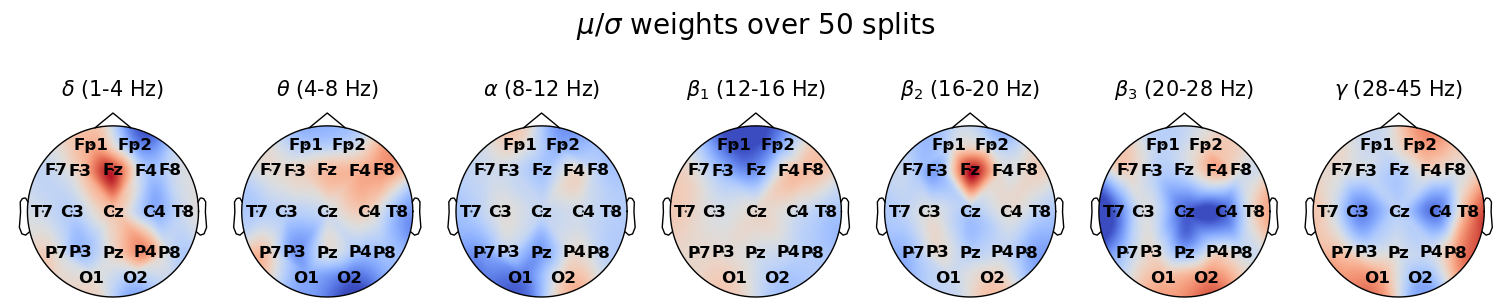

In [78]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# Define frequency bands
flim = [1, 45]
bands = {'$\\delta$' : [flim[0], 4],
         '$\\theta$' : [4, 8],
         '$\\alpha$' : [8, 12],
         '$\\beta_1$': [12, 16],
         '$\\beta_2$': [16, 20],
         '$\\beta_3$': [20, 28],
         '$\\gamma$' : [28, flim[1]]}

# EEG channel names
channels = ['Fp1','Fp2','F7','F3','Fz',
            'F4','F8','T7','C3','Cz',
            'C4','T8','P7','P3','Pz',
            'P4','P8','O1','O2']

# Define montage
montage = 'biosemi64'

# Simulated scalp_avg data (replace with actual data)
# scalp_avg shape: (n_channels, n_bands)

#scalp = (scalp_avg/scalp_std).T

scalp = scalp_avg.T

# Create an MNE info object
info = mne.create_info(channels, sfreq=256, ch_types='eeg')  # Adjust sampling rate if needed
info.set_montage(montage)

# Plot topographies for each frequency band
fig, axes = plt.subplots(1, len(bands), figsize=(15, 5), constrained_layout=True)

for i, (band_name, freq_range) in enumerate(bands.items()):
    data = scalp[:, i]  # Extract data for the current band

    # Create an MNE Evoked object
    evoked = mne.EvokedArray(data[:, np.newaxis], info, tmin=0)

    # Plot topography
    mne.viz.plot_topomap(data, info, axes=axes[i], show=False,
                        cmap='coolwarm',names=channels,
                        vlim=(np.min(scalp),np.max(scalp)), contours=0)
    axes[i].set_title(f"{band_name} ({freq_range[0]}-{freq_range[1]} Hz)",fontsize=15)

    for text in axes[i].texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

fig.text(0.5, 0.85, '$\\mu/\\sigma$ weights over 50 splits', 
         fontsize=20, ha='center', va='center')
plt.show()

fig.savefig(imgPath + 'zscore_weights'+ imgs_format,
            transparent=False, bbox_inches='tight')


In [14]:
# Extract data and labels from each loader
train_data, train_labels = trainloader.dataset[:]
val_data, val_labels = valloader.dataset[:]
test_data, test_labels = testloader.dataset[:]

# Concatenate along the first axis (i.e., sample dimension)
# all_data = np.concatenate([train_data, val_data, test_data], axis=0)
# all_labels = np.concatenate([train_labels, val_labels, test_labels], axis=0)

# all_data = np.concatenate([train_data, val_data], axis=0)
# all_labels = np.concatenate([train_labels, val_labels], axis=0)

all_data = np.concatenate([test_data], axis=0)
all_labels = np.concatenate([test_labels], axis=0)


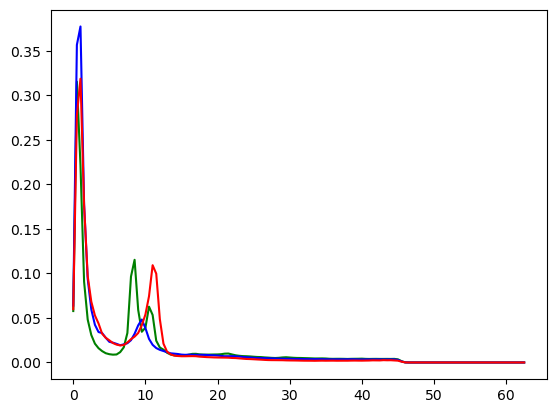

In [55]:
plt.plot(f, np.mean(np.mean(Pxx[:,:,all_labels==0],axis=1),axis=1),color='green')
plt.plot(f, np.mean(np.mean(Pxx[:,:,all_labels==1],axis=1),axis=1),color='blue')
plt.plot(f, np.mean(np.mean(Pxx[:,:,all_labels==2],axis=1),axis=1),color='red')
plt.show()

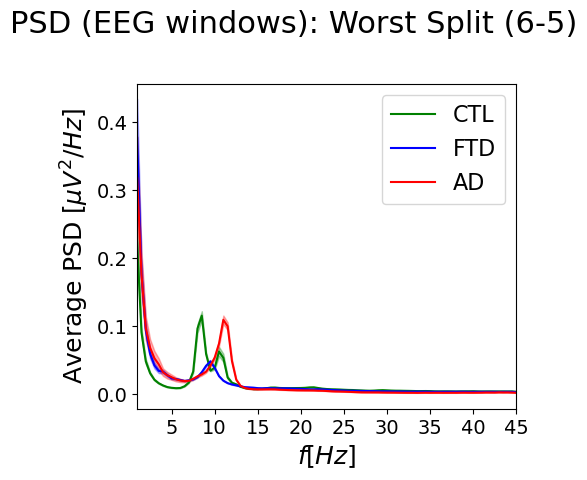

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Compute PSD once
f, Pxx = eegvislib.get_Pxx(all_data, srate=srate)

# Create a 2x4 subplot grid
font = 20
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle('PSD (EEG windows): Worst Split '+f'({outFold}-{inFold})', fontsize=font+2)


# Cluster 0 (green)
mean0 = np.mean(Pxx[:, :, all_labels == 0], axis=1)
std0 = np.std(mean0, axis=1) / np.sqrt(np.shape(mean0)[1])
mean0 = np.mean(mean0,axis=1)
ax.plot(f, mean0, color='green', label='CTL')
ax.fill_between(f, mean0 - std0, mean0 + std0, color='green', alpha=0.3)

# Cluster 1 (blue)
mean1 = np.mean(Pxx[:, :, all_labels == 1], axis=1)
std1 = np.std(mean1, axis=1) / np.sqrt(np.shape(mean1)[1])
mean1 = np.mean(mean1,axis=1)
ax.plot(f, mean1, color='blue', label='FTD')
ax.fill_between(f, mean1 - std1, mean1 + std1, color='blue', alpha=0.3)

# Cluster 2 (red)
mean2 = np.mean(Pxx[:, :, all_labels == 2], axis=1)
std2 = np.std(mean2, axis=1) / np.sqrt(np.shape(mean2)[1])
mean2 = np.mean(mean2,axis=1)
ax.plot(f, mean2, color='red', label='AD')
ax.fill_between(f, mean2 - std2, mean2 + std2, color='red', alpha=0.3)

ax.set_xlim(1, 45)
ax.set_xlabel('$f [Hz]$',fontsize=font-2)
ax.set_ylabel('Average PSD $[\\mu V^2/Hz]$',fontsize=font-2)

for label in ax.get_xticklabels():
    label.set_fontsize(font-6)
for label in ax.get_yticklabels():
    label.set_fontsize(font-6)

ax.legend(fontsize=font-4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

if save_img:
    fig.savefig(imgPath + 'PSD_weightChans' f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')


In [39]:
f, Pxx = eegvislib.get_Pxx(all_data[i, :, :], srate=srate)
f_desired = [1, 4, 8, 12, 16, 20, 28, 45]
findex = eegvislib.get_freq_index(f, f_desired)

In [86]:
band_content = np.zeros((all_data.shape[0],Chan, shallownet_custom_dict['F1']))

# Loop over each EEG window/sample
for i in range(all_data.shape[0]):
    # Compute power spectral density for sample i
    f, Pxx = eegvislib.get_Pxx(all_data[i, :, :], srate=srate)

    # Compute bandpower in each frequency band
    for j in range(shallownet_custom_dict['F1']):
        band_power = np.trapz(Pxx[findex[j]:findex[j+1], :].T, dx=(f[1]-f[0]))  # integrate over frequency
        bandc = 10 * np.log10(band_power / 1)  # log power
        #bandc = band_power
        band_content[i, :, j] = bandc


6721


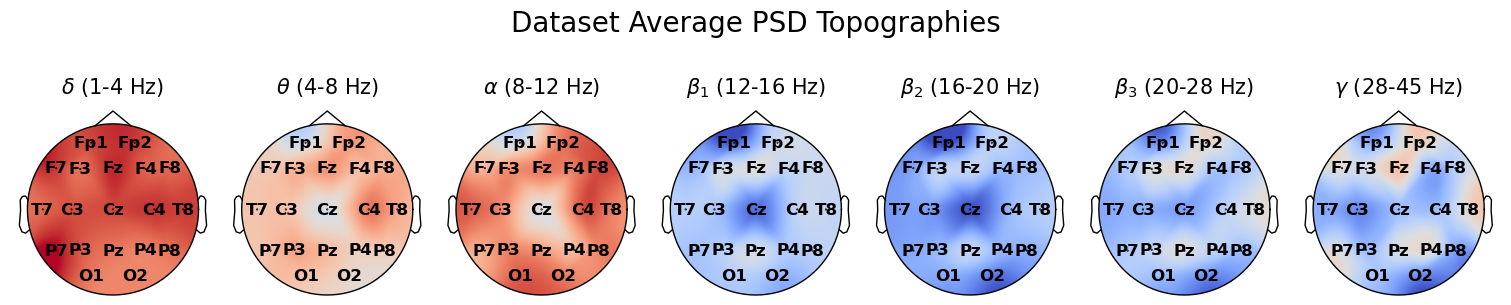

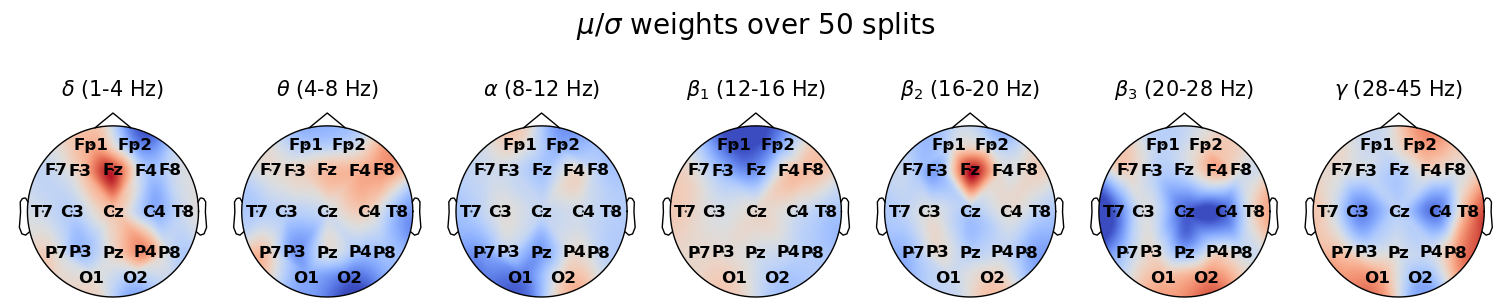

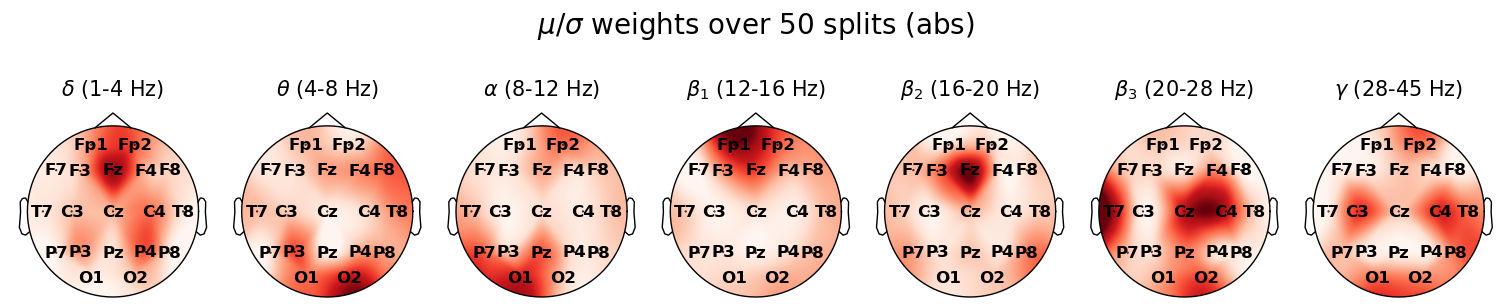

In [87]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# Define frequency bands
flim = [1, 45]
bands = {'$\\delta$' : [flim[0], 4],
         '$\\theta$' : [4, 8],
         '$\\alpha$' : [8, 12],
         '$\\beta_1$': [12, 16],
         '$\\beta_2$': [16, 20],
         '$\\beta_3$': [20, 28],
         '$\\gamma$' : [28, flim[1]]}

# EEG channel names
channels = ['Fp1','Fp2','F7','F3','Fz',
            'F4','F8','T7','C3','Cz',
            'C4','T8','P7','P3','Pz',
            'P4','P8','O1','O2']

# Define montage
montage = 'biosemi64'

# Simulated scalp_avg data (replace with actual data)
# scalp_avg shape: (n_channels, n_bands)
lab = 2
#scalp1 = np.mean(band_content[all_labels==lab,:,:],axis=0)
scalp1 = np.mean(band_content,axis=0)
print(np.sum(all_labels==lab))

# Create an MNE info object
info = mne.create_info(channels, sfreq=256, ch_types='eeg')  # Adjust sampling rate if needed
info.set_montage(montage)

# Plot topographies for each frequency band
fig, axes = plt.subplots(1, len(bands), figsize=(15, 5), constrained_layout=True)

for i, (band_name, freq_range) in enumerate(bands.items()):
    data = scalp1[:, i]  # Extract data for the current band

    # Create an MNE Evoked object
    evoked = mne.EvokedArray(data[:, np.newaxis], info, tmin=0)

    # Plot topography
    mne.viz.plot_topomap(data, info, axes=axes[i], show=False,
                        cmap='coolwarm',names=channels,
                        vlim=(scalp1.min(),scalp1.max()), contours=0)
    axes[i].set_title(f"{band_name} ({freq_range[0]}-{freq_range[1]} Hz)",fontsize=15)

    for text in axes[i].texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

fig.text(0.5, 0.85, 'Dataset Average PSD Topographies', 
         fontsize=20, ha='center', va='center')
plt.show()


# Create an MNE info object
info = mne.create_info(channels, sfreq=256, ch_types='eeg')  # Adjust sampling rate if needed
info.set_montage(montage)

# Plot topographies for each frequency band
fig, axes = plt.subplots(1, len(bands), figsize=(15, 5), constrained_layout=True)

for i, (band_name, freq_range) in enumerate(bands.items()):
    data = scalp_avg.T[:, i]  # Extract data for the current band

    # Create an MNE Evoked object
    evoked = mne.EvokedArray(data[:, np.newaxis], info, tmin=0)

    # Plot topography
    mne.viz.plot_topomap(data, info, axes=axes[i], show=False,
                        cmap='coolwarm',names=channels,
                        vlim=(scalp_avg.min(),scalp_avg.max()), contours=0)
    axes[i].set_title(f"{band_name} ({freq_range[0]}-{freq_range[1]} Hz)",fontsize=15)

    for text in axes[i].texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

fig.text(0.5, 0.85, '$\\mu/\\sigma$ weights over 50 splits', 
         fontsize=20, ha='center', va='center')
plt.show()

# Plot topographies for each frequency band
fig, axes = plt.subplots(1, len(bands), figsize=(15, 5), constrained_layout=True)

for i, (band_name, freq_range) in enumerate(bands.items()):
    data = np.abs(scalp_avg.T[:, i])  # Extract data for the current band

    # Create an MNE Evoked object
    evoked = mne.EvokedArray(data[:, np.newaxis], info, tmin=0)

    # Plot topography
    mne.viz.plot_topomap(data, info, axes=axes[i], show=False,
                        cmap='Reds',names=channels,
                        vlim=(0,np.maximum(np.abs(scalp_avg.min()),scalp_avg.max())), contours=0)
    axes[i].set_title(f"{band_name} ({freq_range[0]}-{freq_range[1]} Hz)",fontsize=15)

    for text in axes[i].texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

fig.text(0.5, 0.85, '$\\mu/\\sigma$ weights over 50 splits (abs)', 
         fontsize=20, ha='center', va='center')
plt.show()

CTL 0.15438596491228068 0.5279958428489308
FTD 0.32280701754385965 0.1776654571308196
AD 0.28070175438596495 0.24439328171471775
TOT 0.23157894736842102 0.3401065100886612


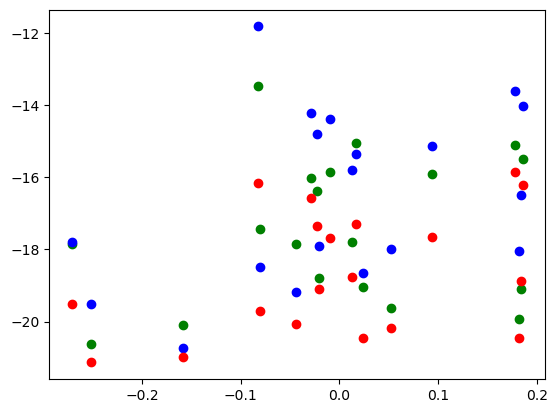

In [94]:
bindex = 6

from scipy.stats import spearmanr

scalp1 = np.mean(band_content[all_labels==0,:,:],axis=0)
plt.scatter(scalp_avg.T[:,bindex],scalp1[:,bindex], color='green')
corr, pval = spearmanr(scalp_avg.T[:,bindex],scalp1[:,bindex])
print('CTL',corr,pval)

scalp1 = np.mean(band_content[all_labels==1,:,:],axis=0)
plt.scatter(scalp_avg.T[:,bindex],scalp1[:,bindex], color='blue')
corr, pval = spearmanr(scalp_avg.T[:,bindex],scalp1[:,bindex])
print('FTD',corr,pval)

scalp1 = np.mean(band_content[all_labels==2,:,:],axis=0)
plt.scatter(scalp_avg.T[:,bindex],scalp1[:,bindex], color='red')
corr, pval = spearmanr(scalp_avg.T[:,bindex],scalp1[:,bindex])
print('AD',corr,pval)

scalp1 = np.mean(band_content,axis=0)
corr, pval = spearmanr(scalp_avg.T[:,bindex],scalp1[:,bindex])
print('TOT',corr,pval)


CTL -0.41052631578947374 0.08083220853041033
FTD -0.25789473684210523 0.28643023354996244
AD -0.3350877192982456 0.16079938595747956
TOT -0.26842105263157895 0.2665098631799817


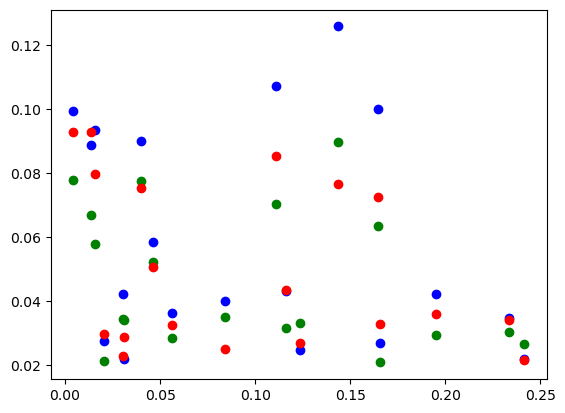

In [179]:
bindex = 6

from scipy.stats import spearmanr

scalp1 = np.mean(band_content[all_labels==0,:,:],axis=0)
plt.scatter(np.abs(scalp_avg.T[:,bindex]),scalp1[:,bindex], color='green')
corr, pval = spearmanr(np.abs(scalp_avg.T[:,bindex]),scalp1[:,bindex])
print('CTL',corr,pval)

scalp1 = np.mean(band_content[all_labels==1,:,:],axis=0)
plt.scatter(np.abs(scalp_avg.T[:,bindex]),scalp1[:,bindex], color='blue')
corr, pval = spearmanr(np.abs(scalp_avg.T[:,bindex]),scalp1[:,bindex])
print('FTD',corr,pval)

scalp1 = np.mean(band_content[all_labels==2,:,:],axis=0)
plt.scatter(np.abs(scalp_avg.T[:,bindex]),scalp1[:,bindex], color='red')
corr, pval = spearmanr(np.abs(scalp_avg.T[:,bindex]),scalp1[:,bindex])
print('AD',corr,pval)

scalp1 = np.mean(band_content,axis=0)
corr, pval = spearmanr(np.abs(scalp_avg.T[:,bindex]),scalp1[:,bindex])
print('TOT',corr,pval)

### Input

In [11]:
layer = None

In [ ]:
batch_IDs = [100]

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']   = [5,5]
spec_dict['font']     = 30
spec_dict['title']    = 'Input Signal'
spec_dict['cbartick'] = 5
spec_dict['f_des']    = [1,6,10,15,18,20,45]
spec_dict['contours'] = 0
spec_dict['lognorm']  = '10log10'
spec_dict['vlim']     = 'all' # 'all' or 'band' or 'batchID'
spec_dict['cmap']     = 'RdBu_r'
spec_dict['figname']  = 'scalpPSD'

%matplotlib inline
for batch_ID in batch_IDs:
    fig = eegvislib.scalpPSD_freq(input_window_normalized, 
                                  spec_dict, inout_labels,
                                  batch_ID)
    
    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}' + f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

In [ ]:
# %matplotlib qt
batch_IDs = [100]
FM_ID = None #None #None (all FM) or a number 0 or list [0], [2,4]

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['FMnames'] = [i for i in spec_dict['bands'].keys()] #or None
spec_dict['backend'] = 'matplotlib' #matplotlib or qt
spec_dict['figname'] = 'EEGwindow'

for batch_ID in batch_IDs:
    fig = eegvislib.channelsTime(input_window_normalized,
                                 Mdl, layer,
                                 spec_dict,
                                 batch_ID, FM_ID)
    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}'+ f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

In [ ]:
batch_IDs = [100]
FM_ID = 0

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']   = [7,7]
spec_dict['times']    = [1, 1.5, 2, 3.5]
spec_dict['cmap']     = 'coolwarm'
spec_dict['cbartick'] = 5
spec_dict['font']     = 30
spec_dict['rotation'] = 90
spec_dict['alpha']    = 0.05
spec_dict['method']   = 'fdr_bh'
spec_dict['contours'] = 0
spec_dict['cmap']     = 'coolwarm'
spec_dict['unit']     =  'z-score []' #or '[$\\mu V]$'
spec_dict['figname']  = 'scalpTimeInput'

for batch_ID in batch_IDs:
    fig = eegvislib.scalpTime(input_window_normalized,
                              Mdl, layer,
                              spec_dict, inout_labels,
                              batch_ID, FM_ID)
    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}'+ f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

In [ ]:
%matplotlib inline

In [16]:
np.shape(all_data)

(1698, 19, 500)

### Conv1

In [12]:
layer = 'encoder.conv1'

KERNELS

In [ ]:
filter_ID     = None #None (all Kernels), a number 0, or a list [0], [0,2]
kernel_ID     = 0
kernel_height = 0

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']      = [6,5]
spec_dict['linew']       = 4
spec_dict['font']        = 28
spec_dict['title']       = f'First Layer Filters'#:  Split ({outFold}-{inFold})'
spec_dict['rotation']    = 45
spec_dict['lognorm']     = '10log10'
spec_dict['bodeplot']    = 'both' #both, phase, mag
spec_dict['colors']      = [['tab:red','black'],['tab:orange','tab:blue']]
spec_dict['linestyle']   = ['-','--']
spec_dict['loc']         = 'best'
spec_dict['nfig']        = [4,3]
spec_dict['filternames'] = [i for i in spec_dict['bands'].keys()] #or None
spec_dict['figname']     = 'firstlayer_preinit' #FiltersBodeplot'

fig, ax = eegvislib.horizontalKernel1D_bode(Mdl_weights, layer,
                                            spec_dict, 
                                            filter_ID, kernel_ID, kernel_height, 
                                            None)

if save_img:
    fig.savefig(imgPath + spec_dict['figname']+ f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')

In [ ]:
filter_ID     = None
kernel_ID     = 0
kernel_height = 0

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']  = [3,3]
spec_dict['font']    = 14
spec_dict['ytick']   = 5
spec_dict['s']       = 2
spec_dict['cmap']    = 'RdBu_r'
spec_dict['figname'] = 'firstLayerFiltersStemplot'

fig = eegvislib.horizontalKernel1D_stem(Mdl_weights, layer, 
                                        spec_dict, 
                                        filter_ID, kernel_ID, kernel_height)

if save_img:
    fig.savefig(imgPath + spec_dict['figname']+ f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')

ACTIVATIONS

In [148]:
convoluted_output  = eegvislib.out_activation(Mdl, layer, input_window_normalized)
convoluted_output.shape
#batch x feature maps x scalp channels x time step

NameError: name 'input_window_normalized' is not defined

In [15]:
convoluted_output  = eegvislib.out_activation(Mdl, layer, torch.tensor(all_data))
convoluted_output.shape

torch.Size([1379, 7, 19, 376])

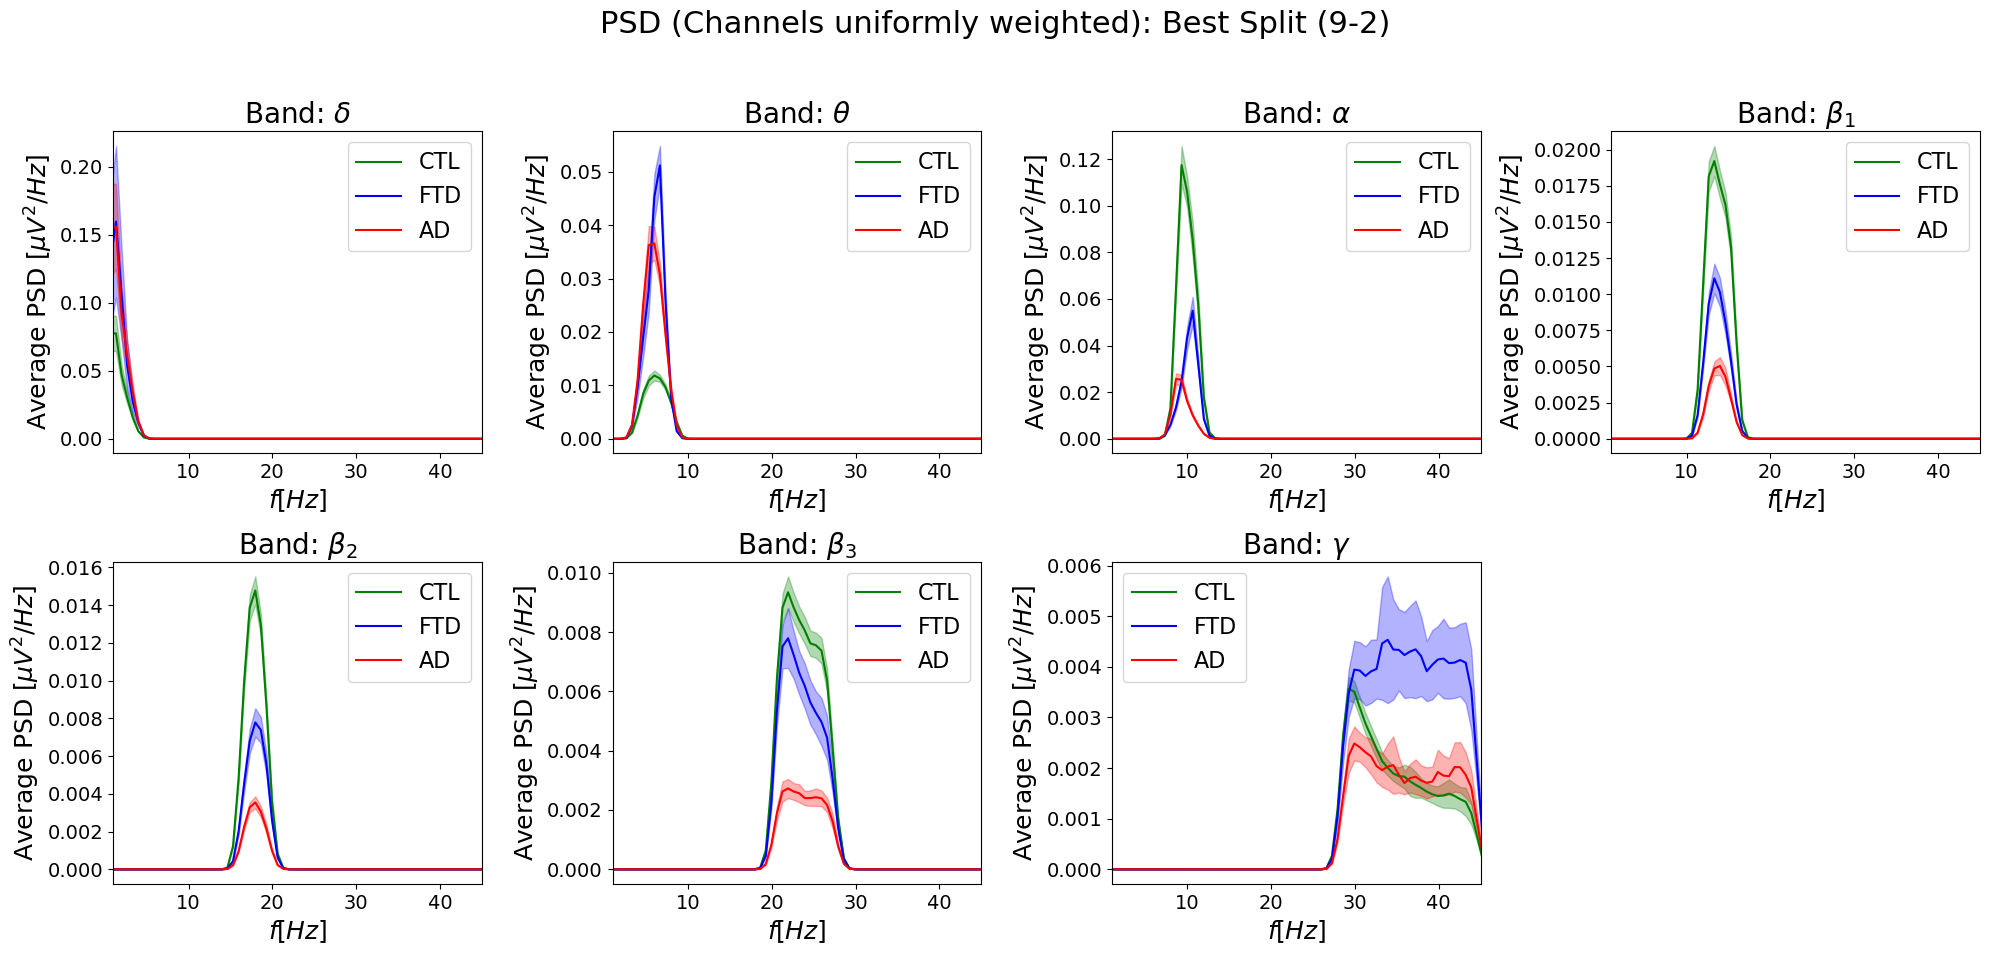

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2-row x 4-column subplot grid (7 plots + 1 empty)
font = 20
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('PSD (Channels uniformly weighted): Best Split '+f'({outFold}-{inFold})', fontsize=font+2)

for i in range(7):
    ax = axes[i // 4, i % 4]  # Calculate subplot index

    f, Pxx = eegvislib.get_Pxx(np.squeeze(convoluted_output[:, i, :, :]), srate=srate)

    # Cluster 0 (green)
    mean0 = np.mean(Pxx[:, :, all_labels == 0], axis=(1, 2))
    std0 = np.std(Pxx[:, :, all_labels == 0], axis=(1, 2)) / np.sqrt(np.sum(all_labels == 0))
    ax.plot(f, mean0, color='green', label='CTL')
    ax.fill_between(f, mean0 - std0, mean0 + std0, color='green', alpha=0.3)

    # Cluster 1 (blue)
    mean1 = np.mean(Pxx[:, :, all_labels == 1], axis=(1, 2))
    std1 = np.std(Pxx[:, :, all_labels == 1], axis=(1, 2)) / np.sqrt(np.sum(all_labels == 1))
    ax.plot(f, mean1, color='blue', label='FTD')
    ax.fill_between(f, mean1 - std1, mean1 + std1, color='blue', alpha=0.3)

    # Cluster 2 (red)
    mean2 = np.mean(Pxx[:, :, all_labels == 2], axis=(1, 2))
    std2 = np.std(Pxx[:, :, all_labels == 2], axis=(1, 2)) / np.sqrt(np.sum(all_labels == 2))
    ax.plot(f, mean2, color='red', label='AD')
    ax.fill_between(f, mean2 - std2, mean2 + std2, color='red', alpha=0.3)

    ax.set_title(f'Band: {list(bands.keys())[i]}',fontsize=font)
    ax.set_xlim(1, 45)
    ax.set_xlabel('$f [Hz]$',fontsize=font-2)
    ax.set_ylabel('Average PSD $[\\mu V^2/Hz]$',fontsize=font-2)

    for label in ax.get_xticklabels():
        label.set_fontsize(font-6)
    for label in ax.get_yticklabels():
        label.set_fontsize(font-6)

    ax.legend(fontsize=font-4)

# Hide the last (8th) empty subplot
fig.delaxes(axes[1, 3])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

if save_img:
    fig.savefig(imgPath + 'PSD_unifChans' f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')


In [25]:
convoluted_output_val = convoluted_output.mean(axis=-1).numpy()

7332


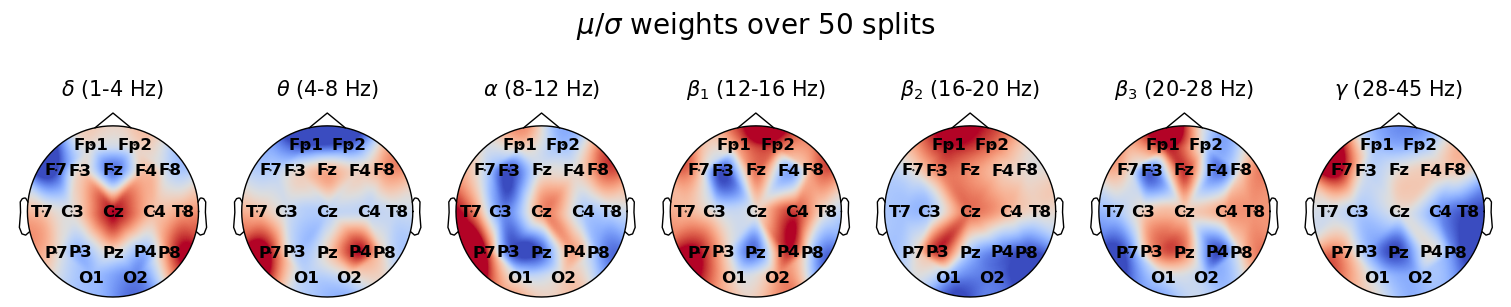

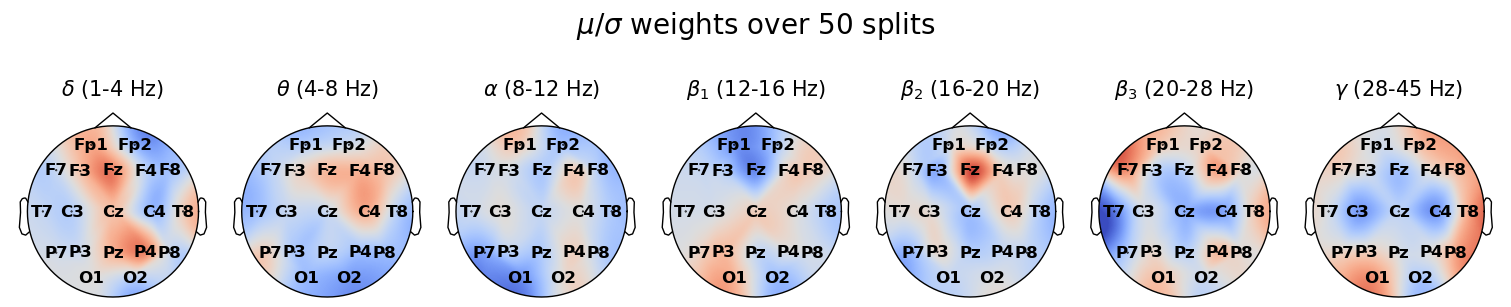

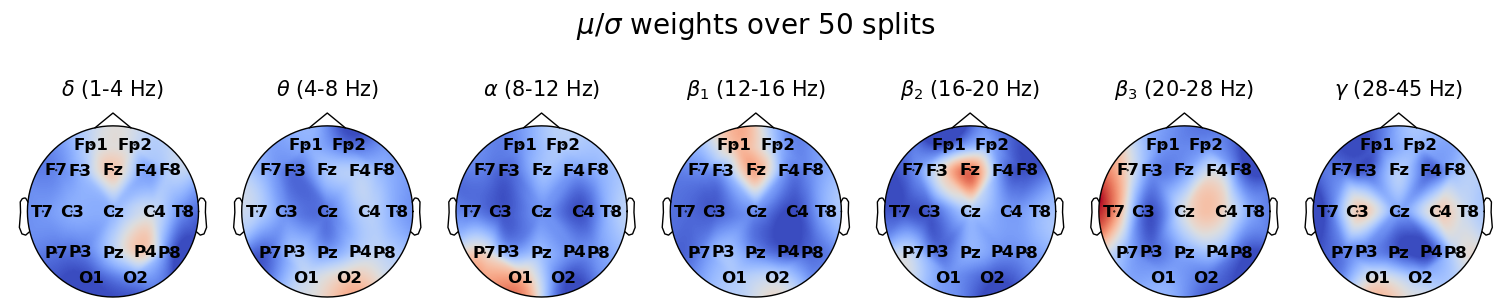

In [27]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# Define frequency bands
flim = [1, 45]
bands = {'$\\delta$' : [flim[0], 4],
         '$\\theta$' : [4, 8],
         '$\\alpha$' : [8, 12],
         '$\\beta_1$': [12, 16],
         '$\\beta_2$': [16, 20],
         '$\\beta_3$': [20, 28],
         '$\\gamma$' : [28, flim[1]]}

# EEG channel names
channels = ['Fp1','Fp2','F7','F3','Fz',
            'F4','F8','T7','C3','Cz',
            'C4','T8','P7','P3','Pz',
            'P4','P8','O1','O2']

# Define montage
montage = 'biosemi64'

# Simulated scalp_avg data (replace with actual data)
# scalp_avg shape: (n_channels, n_bands)
lab = 2
#scalp1 = np.mean(convoluted_output_val[all_labels==lab,:,:],axis=0)
scalp1 = np.mean(convoluted_output_val,axis=0).T
scalp1std = np.std(convoluted_output_val,axis=0).T
print(np.sum(all_labels==lab))

# Create an MNE info object
info = mne.create_info(channels, sfreq=256, ch_types='eeg')  # Adjust sampling rate if needed
info.set_montage(montage)

# Plot topographies for each frequency band
fig, axes = plt.subplots(1, len(bands), figsize=(15, 5), constrained_layout=True)

for i, (band_name, freq_range) in enumerate(bands.items()):
    data = scalp1[:, i]/scalp1std[:,i]  # Extract data for the current band

    # Create an MNE Evoked object
    evoked = mne.EvokedArray(data[:, np.newaxis], info, tmin=0)

    # Plot topography
    mne.viz.plot_topomap(data, info, axes=axes[i], show=False,
                        cmap='coolwarm',names=channels,
                        vlim=(data.min(),data.max()), contours=0)
    axes[i].set_title(f"{band_name} ({freq_range[0]}-{freq_range[1]} Hz)",fontsize=15)

    for text in axes[i].texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

fig.text(0.5, 0.85, '$\\mu/\\sigma$ weights over 50 splits', 
         fontsize=20, ha='center', va='center')
plt.show()


# Create an MNE info object
info = mne.create_info(channels, sfreq=256, ch_types='eeg')  # Adjust sampling rate if needed
info.set_montage(montage)

# Plot topographies for each frequency band
fig, axes = plt.subplots(1, len(bands), figsize=(15, 5), constrained_layout=True)

for i, (band_name, freq_range) in enumerate(bands.items()):
    data = scalp_avg.T[:, i]  # Extract data for the current band

    # Create an MNE Evoked object
    evoked = mne.EvokedArray(data[:, np.newaxis], info, tmin=0)

    # Plot topography
    mne.viz.plot_topomap(data, info, axes=axes[i], show=False,
                        cmap='coolwarm',names=channels,
                        vlim=(-0.4,0.4), contours=0)
    axes[i].set_title(f"{band_name} ({freq_range[0]}-{freq_range[1]} Hz)",fontsize=15)

    for text in axes[i].texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

fig.text(0.5, 0.85, '$\\mu/\\sigma$ weights over 50 splits', 
         fontsize=20, ha='center', va='center')
plt.show()

# Plot topographies for each frequency band
fig, axes = plt.subplots(1, len(bands), figsize=(15, 5), constrained_layout=True)

for i, (band_name, freq_range) in enumerate(bands.items()):
    data = np.abs(scalp_avg.T[:, i])  # Extract data for the current band

    # Create an MNE Evoked object
    evoked = mne.EvokedArray(data[:, np.newaxis], info, tmin=0)

    # Plot topography
    mne.viz.plot_topomap(data, info, axes=axes[i], show=False,
                        cmap='coolwarm',names=channels,
                        vlim=(0,0.4), contours=0)
    axes[i].set_title(f"{band_name} ({freq_range[0]}-{freq_range[1]} Hz)",fontsize=15)

    for text in axes[i].texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

fig.text(0.5, 0.85, '$\\mu/\\sigma$ weights over 50 splits', 
         fontsize=20, ha='center', va='center')
plt.show()

CTL -0.22456140350877193 0.35534598974510767
FTD 0.26666666666666666 0.26976816493501343
AD -0.09649122807017543 0.6943484389585837
TOT -0.05087719298245614 0.8361300467881018


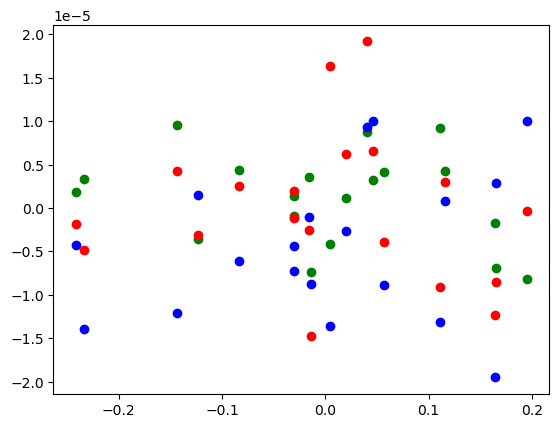

In [215]:
bindex = 6

from scipy.stats import spearmanr

scalp1 = np.mean(convoluted_output_val[all_labels==0,:,:],axis=0).T
plt.scatter(scalp_avg.T[:,bindex],scalp1[:,bindex], color='green')
corr, pval = spearmanr(scalp_avg.T[:,bindex],scalp1[:,bindex])
print('CTL',corr,pval)

scalp1 = np.mean(convoluted_output_val[all_labels==1,:,:],axis=0).T
plt.scatter(scalp_avg.T[:,bindex],scalp1[:,bindex], color='blue')
corr, pval = spearmanr(scalp_avg.T[:,bindex],scalp1[:,bindex])
print('FTD',corr,pval)

scalp1 = np.mean(convoluted_output_val[all_labels==2,:,:],axis=0).T
plt.scatter(scalp_avg.T[:,bindex],scalp1[:,bindex], color='red')
corr, pval = spearmanr(scalp_avg.T[:,bindex],scalp1[:,bindex])
print('AD',corr,pval)

scalp1 = np.mean(convoluted_output_val,axis=0).T
corr, pval = spearmanr(scalp_avg.T[:,bindex],scalp1[:,bindex])
print('TOT',corr,pval)


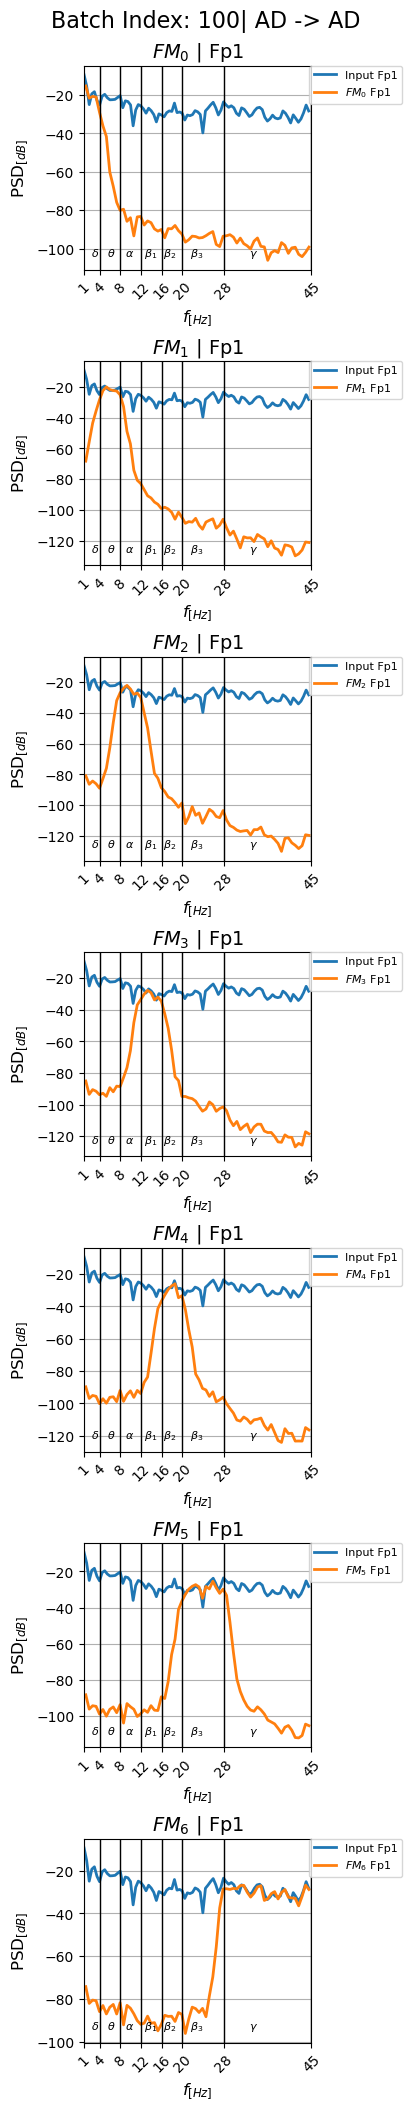

In [14]:
# Parameters
chan_ID   = ['Fp1'] #or multiple channels ['Oz','Fpz']
batch_IDs = [100]
FM_ID     = [0,1,2,3,4,5,6] #None (all FM) or a number 0 or list [0], [2,4]

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']  = [4,3]
spec_dict['linew']   = 2
spec_dict['font']    = 14
spec_dict['lognorm'] = '10log10'
spec_dict['loc']     = 'upper right'
spec_dict['rotation']= 45
spec_dict['typeplot']= 'both' # input or feature or both
spec_dict['figname'] = 'firstLayerActivationsChannels'

for batch_ID in batch_IDs:
    fig = eegvislib.channelsPSD_lines(input_window_normalized,
                                      Mdl, layer,
                                      spec_dict, inout_labels,
                                      chan_ID, batch_ID, FM_ID)
    
    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}'+ f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

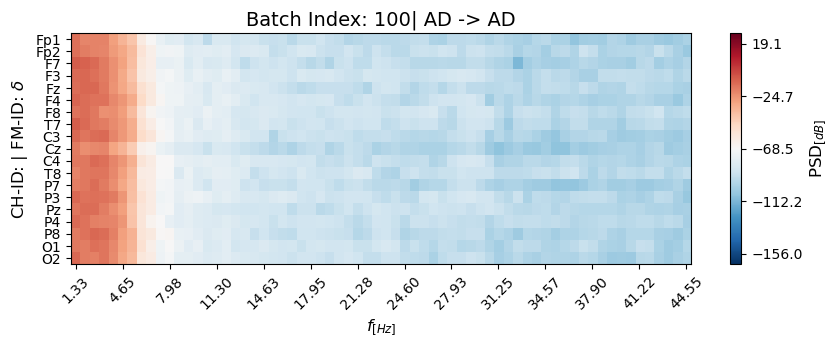

In [15]:
batch_IDs = [100]
FM_ID     = [0] #None (all FM) or a number 0 or list [0], [2,4]
chan_ID   = None

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']   = [10,3]
spec_dict['font']     = 14
spec_dict['title']    = 'PSD_FM'
spec_dict['cbartick'] = 5
spec_dict['ytick']    = [[i for i in spec_dict['bands'].keys()],spec_dict['channels']]  #or [None, None]
spec_dict['rotation'] = 45
spec_dict['groupby']  = [5,1]
spec_dict['lognorm']  = '10log10'
spec_dict['cmap']     = 'RdBu_r'
spec_dict['figname']  = 'secondLayerActivationsPSD'

for batch_ID in batch_IDs:
    fig = eegvislib.channelsPSD_box(input_window_normalized, 
                                   Mdl, layer,
                                   spec_dict, inout_labels,
                                   batch_ID, FM_ID, chan_ID)

    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}'+ f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

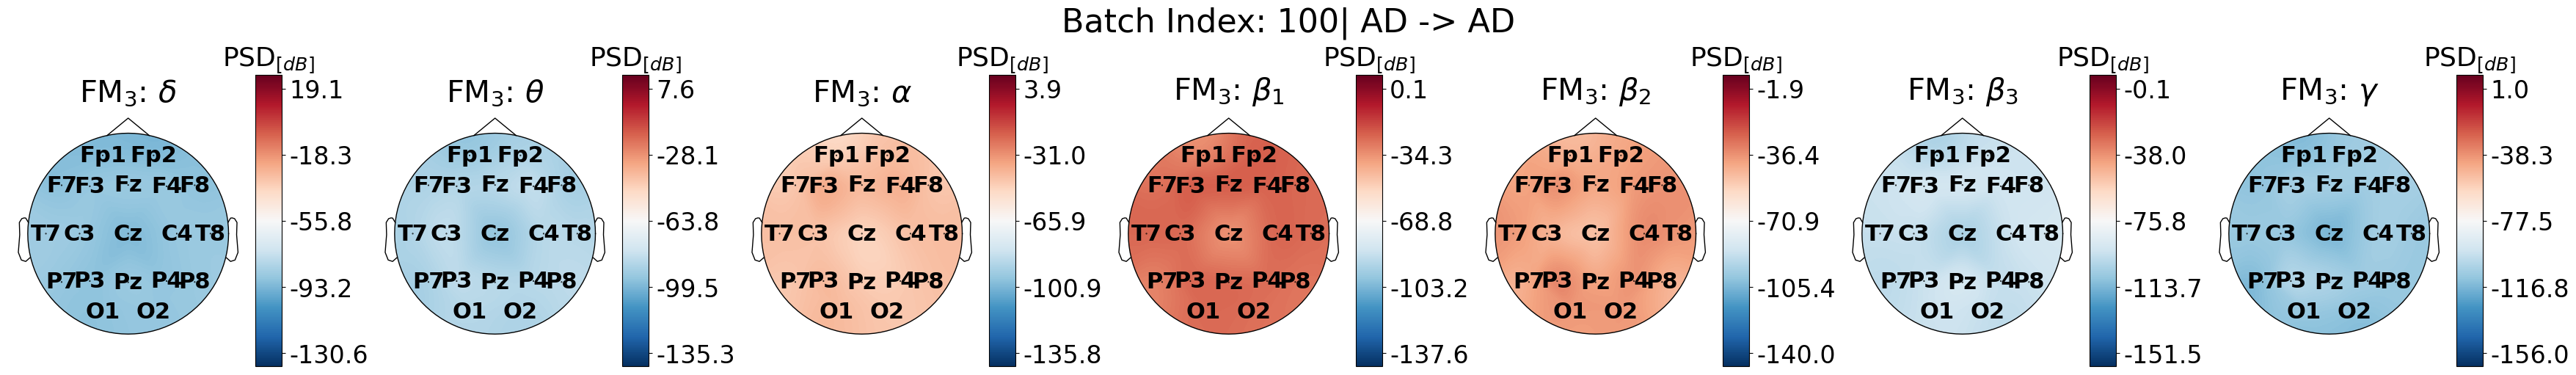

In [16]:
batch_IDs = [100]
FM_ID     = [3] #None (all FM) or a number 0 or list [0], [2,4]

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']   = [5,5]
spec_dict['font']     = 30
spec_dict['cbartick'] = 5
spec_dict['contours'] = 0  
spec_dict['lognorm']  = '10log10'
spec_dict['vlim']     = 'band' # 'all' or 'band' or 'batchID'
spec_dict['cmap']     = 'RdBu_r'
spec_dict['figname']  = 'firstLayerActivationsPSD'

for batch_ID in batch_IDs:
    fig = eegvislib.scalpPSD_band(input_window_normalized, 
                                  Mdl, layer, 
                                  spec_dict, inout_labels,
                                  batch_ID, FM_ID)
    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}'+ f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

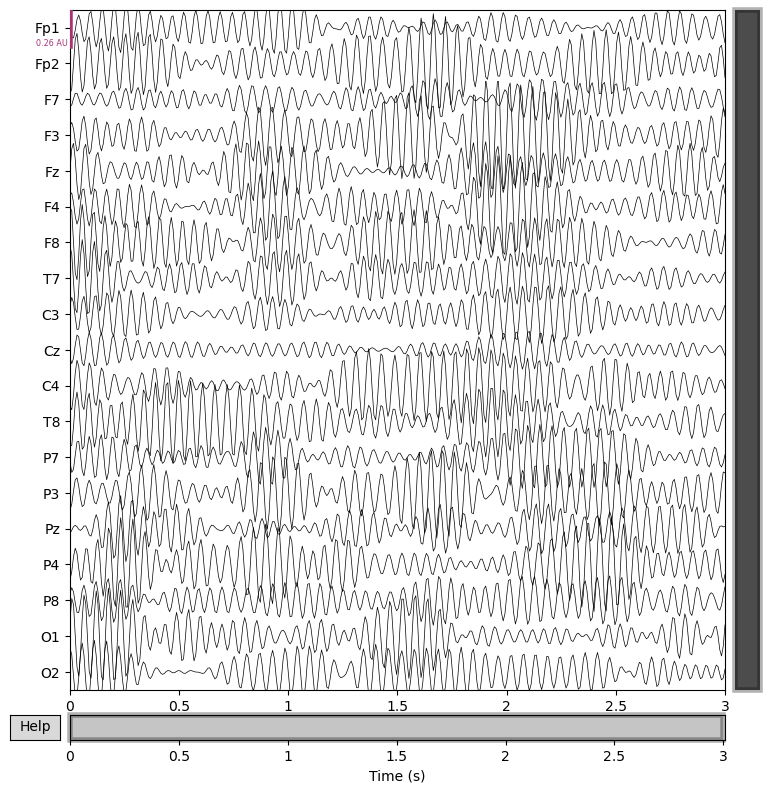

In [22]:
batch_IDs = [100]
FM_ID = [4] #None #None (all FM) or a number 0 or list [0], [2,4]

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['FMnames'] = channels #[i for i in spec_dict['bands'].keys()] #or None
spec_dict['backend'] = 'matplotlib' #matplotlib or qt
spec_dict['figname'] = 'temporalFMLayer1'

for batch_ID in batch_IDs:
    fig = eegvislib.channelsTime(input_window_normalized,
                                 Mdl, layer,
                                 spec_dict,
                                 batch_ID, FM_ID)
    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}'+ f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

In [ ]:
batch_IDs = [100]
FM_ID     = [0,1]

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']   = [7,7]
spec_dict['times']    = [1, 1.5, 2, 3.5]
spec_dict['cbartick'] = 5
spec_dict['font']     = 30
spec_dict['rotation'] = 90
spec_dict['alpha']    = 0.05
spec_dict['method']   = 'fdr_bh'
spec_dict['cmap']     = 'coolwarm'
spec_dict['contours'] = 0
spec_dict['unit']     =  'z-score' #or '$\\mu V$'
spec_dict['figname']  = 'scalpTimeConv1'

for batch_ID in batch_IDs:
    fig = eegvislib.scalpTime(input_window_normalized,
                              Mdl, layer,
                              spec_dict, inout_labels,
                              batch_ID, FM_ID)
    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}'+ f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

### Conv2

In [17]:
layer = 'encoder.conv2'

KERNEL

In [ ]:
filter_ID    = None #None (all Kernels), a number 0, or a list [0], [0,2]
kernel_ID    = [0] #None (all FM), a number 0, or a list [0], [0,2]
kernel_width = 0

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']      = [5,5]
spec_dict['font']        = 30
spec_dict['title']       = f'Second Layer Filters: Split ({outFold}-{inFold})'
spec_dict['cbartick']    = 5
spec_dict['norm']        = 'nothing' #nothing, or softmax or abs
spec_dict['min_softmax'] = 1/len(channels) # 0 or 1/len(list_channels) (random chance)
spec_dict['filternames'] = [i for i in spec_dict['bands'].keys()] #or None
spec_dict['contours']    = 0
spec_dict['vlim']        = [-0.4,0.4]
spec_dict['cmap']        = ['RdBu_r','Reds'] #two colormaps, one for weights, and one for abs(weights)
spec_dict['figname']     = 'secondLayerFilters'

fig = eegvislib.verticalKernel1D_scalp(Mdl_weights, layer, 
                                       spec_dict,
                                       filter_ID, kernel_ID, kernel_width, 
                                       None)

if save_img:
    fig.savefig(imgPath + spec_dict['figname'] + f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')

In [ ]:
importlib.reload(eegvislib)

ACTIVATION

In [48]:
convoluted_output  = eegvislib.out_activation(Mdl, layer, input_window_normalized)
convoluted_output.shape
#batch x feature maps x scalp channels x time step

NameError: name 'input_window_normalized' is not defined

In [18]:
convoluted_output  = eegvislib.out_activation(Mdl, layer, torch.tensor(all_data))
convoluted_output.shape

torch.Size([1379, 7, 1, 376])

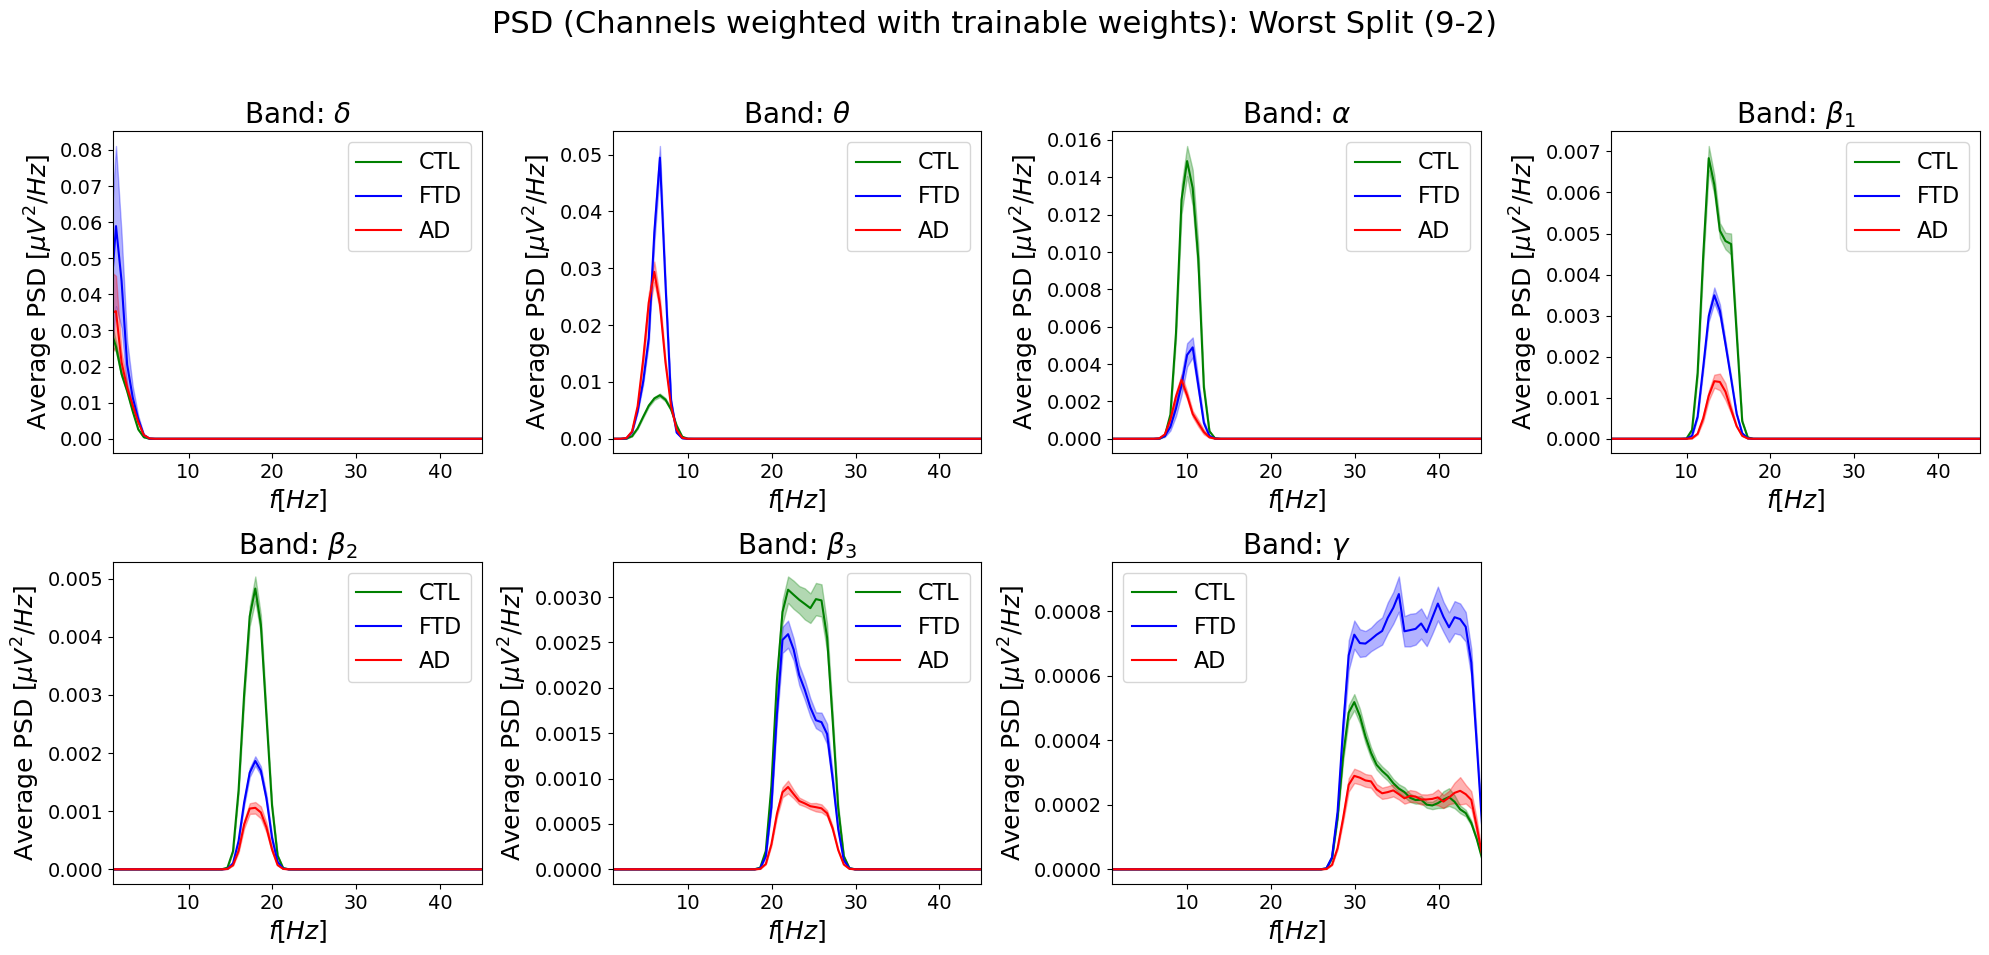

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Compute PSD once
f, Pxx = eegvislib.get_Pxx(torch.squeeze(convoluted_output), srate=srate)

# Create a 2x4 subplot grid
font = 20
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('PSD (Channels weighted with trainable weights): Worst Split '+f'({outFold}-{inFold})', fontsize=font+2)

for i in range(7):
    ax = axes[i // 4, i % 4]  # Row-major indexing

    # Cluster 0 (green)
    mean0 = np.mean(Pxx[:, i, all_labels == 0], axis=1)
    std0 = np.std(Pxx[:, i, all_labels == 0], axis=1) / np.sqrt(np.sum(all_labels == 0))
    ax.plot(f, mean0, color='green', label='CTL')
    ax.fill_between(f, mean0 - std0, mean0 + std0, color='green', alpha=0.3)

    # Cluster 1 (blue)
    mean1 = np.mean(Pxx[:, i, all_labels == 1], axis=1)
    std1 = np.std(Pxx[:, i, all_labels == 1], axis=1) / np.sqrt(np.sum(all_labels == 1))  # Corrected denominator
    ax.plot(f, mean1, color='blue', label='FTD')
    ax.fill_between(f, mean1 - std1, mean1 + std1, color='blue', alpha=0.3)

    # Cluster 2 (red)
    mean2 = np.mean(Pxx[:, i, all_labels == 2], axis=1)
    std2 = np.std(Pxx[:, i, all_labels == 2], axis=1) / np.sqrt(np.sum(all_labels == 2))  # Corrected denominator
    ax.plot(f, mean2, color='red', label='AD')
    ax.fill_between(f, mean2 - std2, mean2 + std2, color='red', alpha=0.3)

    ax.set_title(f'Band: {list(bands.keys())[i]}',fontsize=font)
    ax.set_xlim(1, 45)
    ax.set_xlabel('$f [Hz]$',fontsize=font-2)
    ax.set_ylabel('Average PSD $[\\mu V^2/Hz]$',fontsize=font-2)

    for label in ax.get_xticklabels():
        label.set_fontsize(font-6)
    for label in ax.get_yticklabels():
        label.set_fontsize(font-6)

    ax.legend(fontsize=font-4)

# Remove the last empty subplot
fig.delaxes(axes[1, 3])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

if save_img:
    fig.savefig(imgPath + 'PSD_weightChans' f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')



In [52]:
all_labels

array([2, 2, 2, ..., 1, 1, 1])

In [ ]:
batch_IDs = [100]
FM_ID = None #None (all FM) or a number 0 or list [0], [2,4]

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']   = [10,3]
spec_dict['font']     = 14
spec_dict['title']    = 'PSD_FM'
spec_dict['cbartick'] = 5
spec_dict['rotation'] = 45
spec_dict['ytick']    = [[i for i in spec_dict['bands'].keys()], None]
spec_dict['groupby']  = [5,1]
spec_dict['lognorm']  = '10log10'
spec_dict['cmap']     = 'RdBu_r'
spec_dict['figname']  = 'secondLayerActivationsPSD'

for batch_ID in batch_IDs:
    fig = eegvislib.channelsPSD_box(input_window_normalized, 
                                   Mdl, layer,
                                   spec_dict, inout_labels,
                                   batch_ID, FM_ID)

    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}'+ f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

In [ ]:
# %matplotlib qt
batch_IDs = [100]
FM_ID = None #None #None (all FM) or a number 0 or list [0], [2,4]

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['FMnames'] = [i for i in spec_dict['bands'].keys()] #or None
spec_dict['backend'] = 'matplotlib' #matplotlib or qt
spec_dict['figname'] = 'temporalFMLayer2'

for batch_ID in batch_IDs:
    fig = eegvislib.channelsTime(input_window_normalized,
                                 Mdl, layer,
                                 spec_dict,
                                 batch_ID, FM_ID)
    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}'+ f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

### Batch Normalization

In [56]:
layer = 'encoder.batch1'

In [57]:
convoluted_output  = eegvislib.out_activation(Mdl, layer, torch.tensor(all_data))
convoluted_output.shape

torch.Size([1698, 7, 1, 376])

ACTIVATION

In [ ]:
# %matplotlib qt
batch_IDs = [100]
FM_ID = None #None #None (all FM) or a number 0 or list [0], [2,4]

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['FMnames'] = [i for i in spec_dict['bands'].keys()] #or None
spec_dict['backend'] = 'matplotlib' #matplotlib or qt
spec_dict['figname'] = 'temporalFMLayer2'

for batch_ID in batch_IDs:
    fig = eegvislib.channelsTime(input_window_normalized,
                                 Mdl, layer,
                                 spec_dict,
                                 batch_ID, FM_ID)
    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}'+ f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

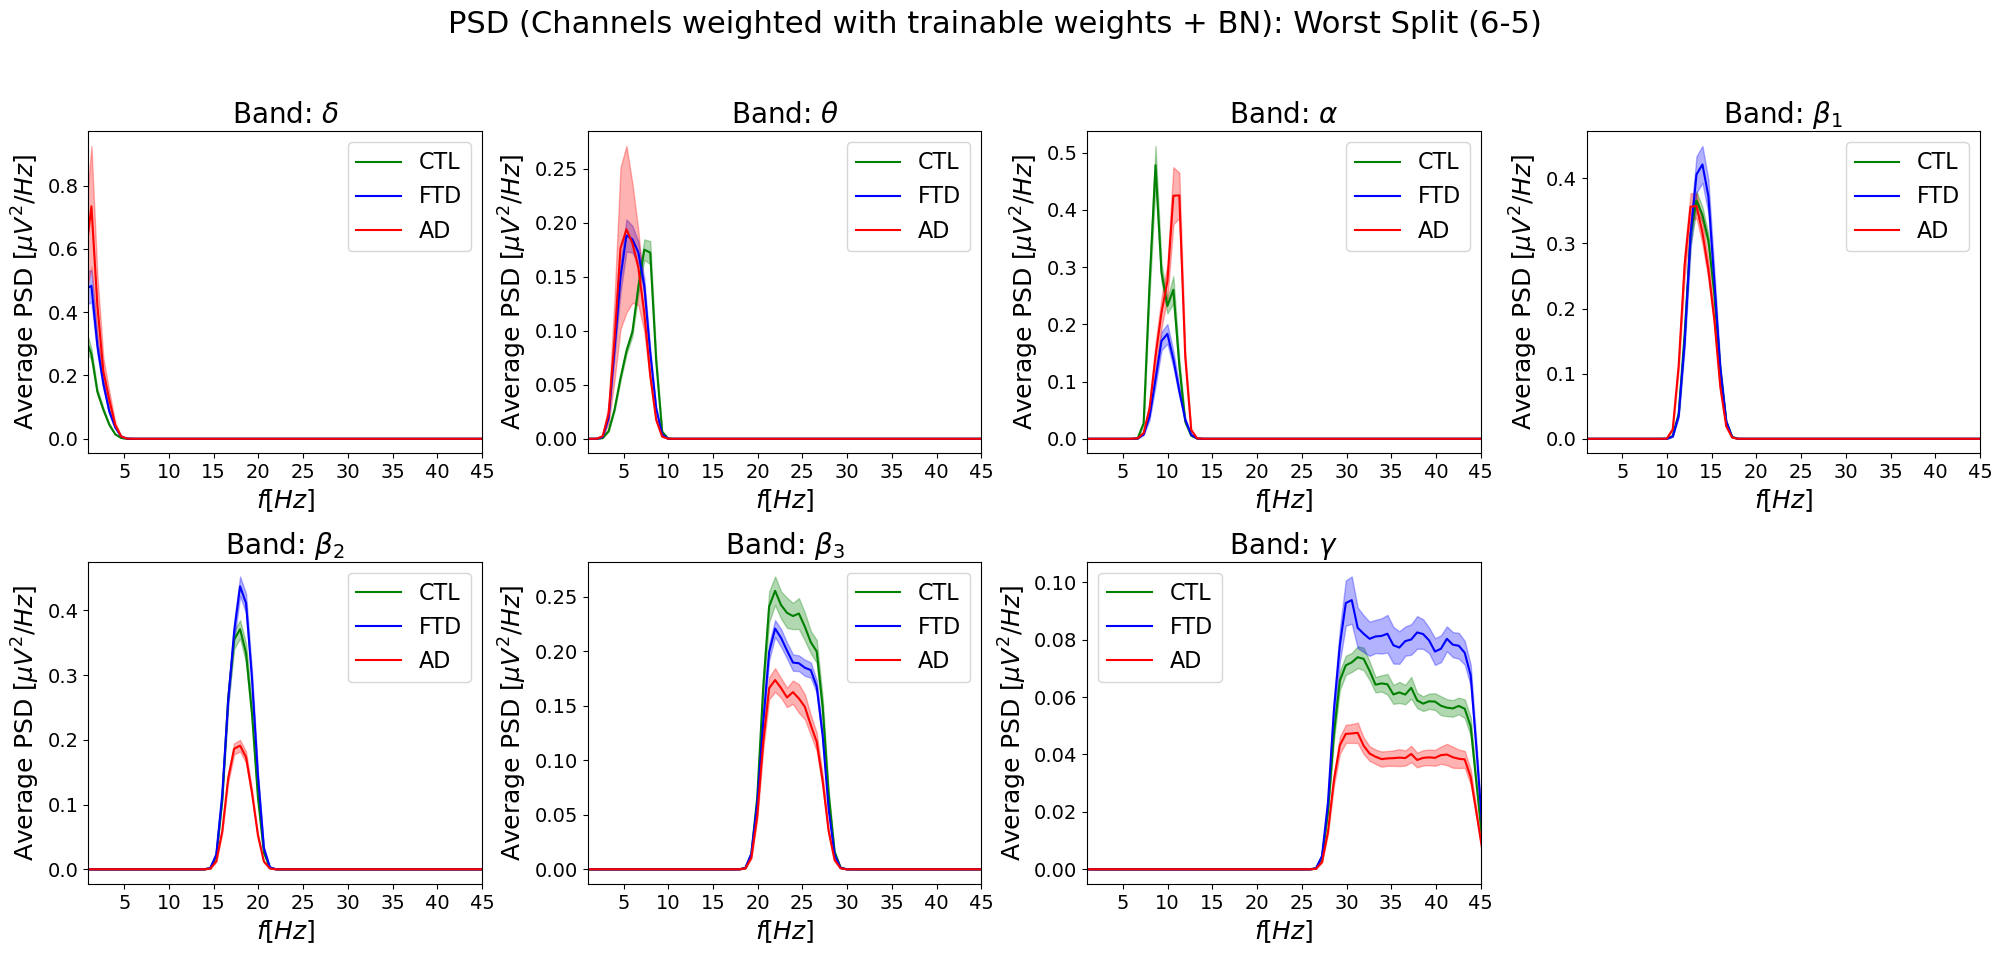

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Compute PSD once
f, Pxx = eegvislib.get_Pxx(torch.squeeze(convoluted_output), srate=srate)

# Create a 2x4 subplot grid
font = 20
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('PSD (Channels weighted with trainable weights + BN): Worst Split '+f'({outFold}-{inFold})', fontsize=font+2)

for i in range(7):
    ax = axes[i // 4, i % 4]  # Row-major indexing

    # Cluster 0 (green)
    mean0 = np.mean(Pxx[:, i, all_labels == 0], axis=1)
    std0 = np.std(Pxx[:, i, all_labels == 0], axis=1) / np.sqrt(np.sum(all_labels == 0))
    ax.plot(f, mean0, color='green', label='CTL')
    ax.fill_between(f, mean0 - std0, mean0 + std0, color='green', alpha=0.3)

    # Cluster 1 (blue)
    mean1 = np.mean(Pxx[:, i, all_labels == 1], axis=1)
    std1 = np.std(Pxx[:, i, all_labels == 1], axis=1) / np.sqrt(np.sum(all_labels == 1))  # Corrected denominator
    ax.plot(f, mean1, color='blue', label='FTD')
    ax.fill_between(f, mean1 - std1, mean1 + std1, color='blue', alpha=0.3)

    # Cluster 2 (red)
    mean2 = np.mean(Pxx[:, i, all_labels == 2], axis=1)
    std2 = np.std(Pxx[:, i, all_labels == 2], axis=1) / np.sqrt(np.sum(all_labels == 2))  # Corrected denominator
    ax.plot(f, mean2, color='red', label='AD')
    ax.fill_between(f, mean2 - std2, mean2 + std2, color='red', alpha=0.3)

    ax.set_title(f'Band: {list(bands.keys())[i]}',fontsize=font)
    ax.set_xlim(1, 45)
    ax.set_xlabel('$f [Hz]$',fontsize=font-2)
    ax.set_ylabel('Average PSD $[\\mu V^2/Hz]$',fontsize=font-2)

    for label in ax.get_xticklabels():
        label.set_fontsize(font-6)
    for label in ax.get_yticklabels():
        label.set_fontsize(font-6)

    ax.legend(fontsize=font-4)

# Remove the last empty subplot
fig.delaxes(axes[1, 3])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

if save_img:
    fig.savefig(imgPath + 'PSD_weightChansBN' f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')


### Dense

In [ ]:
layer = 'Dense'

KERNEL

In [ ]:
spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']    = [5,2.5]
spec_dict['font']      = 14
spec_dict['title']     = f'Dense Layer Weights: Split ({outFold}-{inFold})'
spec_dict['cbartick']  = 5
spec_dict['plot_type'] = 'both'
spec_dict['xticks']    = [i for i in spec_dict['bands'].keys()] #or None
spec_dict['groupby']   = 1
spec_dict['cmap']      = 'RdBu_r'
spec_dict['figname']   = 'denseLayerWeights'

fig, mask = eegvislib.denseweights_plot(Mdl_weights,layer,
                                        spec_dict)

if save_img:
    fig.savefig(imgPath + spec_dict['figname'] + f'{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')

ACTIVATION

In [ ]:
layer = 'encoder'
convoluted_output = eegvislib.out_activation(Mdl, layer, input_window_normalized)
convoluted_output.shape
#batch x feature maps x scalp channels x timestep

In [ ]:
batch_IDs = [100]

spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']   = [15,1.5]
spec_dict['linew']    = 2
spec_dict['font']     = 20
spec_dict['rotation'] = 90
spec_dict['groupby']  = 1
spec_dict['cmap']     = 'RdBu_r'
spec_dict['figname']  = 'flattenLayerActivations'

for batch_ID in batch_IDs:
    fig = eegvislib.flatten_fm(input_window_normalized,
                               Mdl, layer, 
                               spec_dict, inout_labels,
                               batch_ID)
    if save_img:
        fig.savefig(imgPath + spec_dict['figname'] + f'_batch{batch_ID}' + f'_split{outFold}_{inFold}' + imgs_format,
                    transparent=False, bbox_inches='tight')

In [ ]:
spec_dict = eegvislib.get_spec_dict(spec_dict_keys, spec_dict_bands)
spec_dict['figdim']  = [5,5]
spec_dict['s']       = 10
spec_dict['loc']     = 'upper left'
spec_dict['font']    = 20
spec_dict['norm']    = 10
spec_dict['lognorm'] = '10log10'
spec_dict['pval']    = 0.05
spec_dict['method']  = 'holm'
spec_dict['figname'] = 'flattenCorrelationPSD'

fig = eegvislib.flattenCorrelationPSD(input_window_normalized, 
                                      Mdl, layer,
                                      spec_dict)

if save_img:
    fig.savefig(imgPath + spec_dict['figname'] + f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')

## Overlap

In [ ]:
layer = 'Dense'
input_window_normalized      = testloader.dataset[:][0]
convoluted_output_test       = eegvislib.out_activation(Mdl, layer, input_window_normalized)

validation_window_normalized = valloader.dataset[:][0]
convoluted_output_val        = eegvislib.out_activation(Mdl, layer, validation_window_normalized)

training_window_normalized   = trainloader.dataset[:][0]
convoluted_output_train      = eegvislib.out_activation(Mdl, layer, training_window_normalized)

In [ ]:
embeddingF   = torch.cat((convoluted_output_test, convoluted_output_val, convoluted_output_train), dim=0).numpy()
labels_test  = [classlabels[i] for i in testloader.dataset[: ][1].to(device = 'cpu').numpy()]
labels_val   = [classlabels[i] for i in valloader.dataset[ : ][1].to(device = 'cpu').numpy()]
labels_train = [classlabels[i] for i in trainloader.dataset[:][1].to(device = 'cpu').numpy()]
labels       = [labels_test, labels_val, labels_train]

In [ ]:
spec_dict ={'title': f'ACTIVATION 3D: Sets | Split {outFold}-{inFold}',
            'alpha_trainval': 1,
            's_trainval': 1,
            'alpha_test': 1,
            's_test': 1,
            'font': 16,
            'figdim': [12, 12],
            'marker': '.',
            'loc': 'upper left',
            'cmap': ['Greys_r','Reds_r'],
            'view': {'elev':None,'azim':None,'roll':None},
            'level': 0.3173,
            'sigmalevels': np.arange(0,3.5,0.5),
            'sigmath': 1, #or None
            'gridsize': 50j,
            'sets': ['TRAIN','TEST'],
            'classlabels': classlabels,
            'figname': 'overlap3Dsplit'}

#%matplotlib qt

fig, ax, overlap = eegvislib.embedding_split3D(embeddingF, labels,
                                               spec_dict)
print(f"overlap_traintest={overlap}")

### TRAIN-VALIDATION-TEST

2D VISUALIZATION

In [ ]:
spec_dict ={'title': '',
            'alpha_trainval': 0.5,
            's_trainval': 4,
            'alpha_test': 1,
            's_test': 10,
            'font': 16,
            'figdim': [10, 10],
            'marker': '.',
            'colors': ['tab:orange','blue', 'k'], #TEST, VAL, TRAIN
            'colors_lines': ['tab:red','violet', 'gray'], #TEST, VAL, TRAIN
            'loc': 'upper left',
            'linew': 2,
            'level': 0.3173,#0.046, #0.3173
            'gridsize': 50j,
            'sets': ['TRAIN','VAL','TEST'],
            'figname': 'overlap2Dsplit'}

# Main figure with subplots
dim = [[0, 1], [2, 1], [0, 2]]
fig, axes = plt.subplots(2, 2, figsize=(10, 10),
                         constrained_layout=True)
fig.suptitle(f'ACTIVATION 2D: Sets | Split {outFold}-{inFold}',
             fontsize=spec_dict['font']+2)

for i, ax in enumerate(axes.flat[:3]):
    spec_dict['dim'] = dim[i]
    spec_dict['xlabel'] = 'Output Activation ' + classlabels[dim[i][0]]
    spec_dict['ylabel'] = 'Output Activation ' + classlabels[dim[i][1]]
    eegvislib.embedding_split2D(embeddingF[:, dim[i]], labels, 
                                spec_dict, 
                                ax=ax)
    
fig.delaxes(axes[1, 1])

if save_img:
    fig.savefig(imgPath + spec_dict['figname']+ f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')

3D VISUALIZATION

In [ ]:
spec_dict ={'title': f'ACTIVATION 3D: Sets | Split {outFold}-{inFold}',
            'alpha_trainval': 1,
            's_trainval': 1,
            'alpha_test': 1,
            's_test': 1,
            'font': 16,
            'figdim': [12, 12],
            'marker': '.',
            'loc': 'upper left',
            'cmap': ['Greys_r','Reds_r'],
            'view': {'elev':None,'azim':None,'roll':None},
            'level': 0.3173,
            'sigmalevels': np.arange(0,3.5,0.5),
            'sigmath': 1, #or None
            'gridsize': 50j,
            'sets': ['TRAIN','TEST'],
            'classlabels': classlabels,
            'figname': 'overlap3Dsplit'}

#%matplotlib qt

fig, ax, overlap = eegvislib.embedding_split3D(embeddingF, labels,
                                               spec_dict)
print(f'Overlap: {overlap:.1%} of {spec_dict['sets'][1]} set on {spec_dict['sets'][0]} set')

if save_img:
    fig.savefig(imgPath + spec_dict['figname'] + f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')

### LABELS

2D VISUALIZATION

In [ ]:
spec_dict = {'title': '',
             'alpha':0.5,
             's':4,
             'alpha_triangle': 0.7,
             'font':16,
             'figdim':[15,15],
             'marker':'.',
             'colors':['tab:green','tab:blue','tab:red'],
             'loc':'upper left',
             'linew': 3,
             'level': 0.3173,
             'sets': ['TEST','TRAIN'],
             'classlabels': classlabels,
             'figname': 'overlap2Dlabels'}

# Main figure with subplots
dim = [[0, 1], [2, 1], [0, 2]]
fig, axes = plt.subplots(2, 2, figsize=(spec_dict['figdim'][0], spec_dict['figdim'][1]),
                         constrained_layout=True)
fig.suptitle(f'ACTIVATION 2D: Labels | Split {outFold}-{inFold}',
             fontsize=spec_dict['font']+2)

for i, ax in enumerate(axes.flat[:3]):
    spec_dict['dim'] = dim[i]
    spec_dict['xlabel'] = 'Output Activation ' + classlabels[dim[i][0]]
    spec_dict['ylabel'] = 'Output Activation ' + classlabels[dim[i][1]]
    eegvislib.embedding_labels2D(embeddingF[:, dim[i]], labels, 
                                 spec_dict, 
                                 ax=ax)

fig.delaxes(axes[1, 1])

if save_img:
    fig.savefig(imgPath + spec_dict['figname'] + f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')

3D VISUALIZATION

In [ ]:
spec_dict ={'title': f'ACTIVATION 3D: Labels | Split {outFold}-{inFold}',
            'alpha': 0.4,
            's': 4,
            'alpha_triangle': 0.7,
            'font': 16,
            'figdim': [12, 12],
            'marker': '.',
            'colors':['tab:green','tab:blue','tab:red'],
            'loc': 'upper left',
            'linew': 2,
            'sets': ['TRAIN'],
            'classlabels': classlabels,
            'figname': 'overlap3Dlabels'}

#%matplotlib qt
fig, ax, baricenters, area = eegvislib.embedding_labels3D(embeddingF, labels,
                                                          spec_dict)

if save_img:
    fig.savefig(imgPath + spec_dict['figname'] + f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')

### TEST SUBJECTS AND CLASSIFICATION MISTAKES

In [ ]:
nw_test = np.concatenate(([testset.EEGcumlen[0]],  np.diff(testset.EEGcumlen)))

colors_test = []
for i in range(len(nw_test)):
    colors_test.extend([plt.cm.tab10.colors[i % 10]]*nw_test[i])

In [ ]:
spec_dict = {'title': '',
             'alpha_test':1,
             'alpha_trainval':0.5,
             's_test':20,
             's_trainval':4,
             'font':16,
             'figdim':[15,15],
             'marker':'.',
             'loc':'lower right',
             'loc_subj': 'lower left',
             'linew': 2,
             'level': 0.3173,
             'nsub': (len(partition_list[0][0]) + len(partition_list[0][1]) + len(partition_list[0][2])),
             'gridsize': 50j,
             'mode': 'subjects', #classification or subjects
             'figname': 'overlap2Dclassification'}

dim = [[0, 1], [2, 1], [0, 2]]
fig, axes = plt.subplots(2, 2, figsize=(spec_dict['figdim'][0], spec_dict['figdim'][1]),
                         constrained_layout=True)
fig.suptitle(f'ACTIVATION 2D: Classification Mistakes | Split {outFold}-{inFold}',
             fontsize=spec_dict['font']+2)

for i, ax in enumerate(axes.flat[:3]):
    spec_dict['xlabel'] = 'Output Activation ' + classlabels[dim[i][0]]
    spec_dict['ylabel'] = 'Output Activation ' + classlabels[dim[i][1]]
    eegvislib.embedding_class2D(embeddingF[:,dim[i]], inout_labels,
                                spec_dict, 
                                test_id, nw_test, colors_test, 
                                ax=ax)

fig.delaxes(axes[1, 1])

if save_img:
    fig.savefig(imgPath + spec_dict['figname']+ f'_split{outFold}_{inFold}' + imgs_format,
                transparent=False, bbox_inches='tight')

In [ ]:
importlib.reload(eegvislib)